# Analyse Prédictive pour l’Optimisation du Transport Public

Ce notebook vise à explorer, nettoyer et préparer les données de fréquentation du transport public de 2019 à 2025, puis à entraîner des modèles de machine learning afin de prédire le nombre de passagers.
Il couvre le nettoyage des données, le feature engineering, l’EDA et l’évaluation des performances des modèles, dans l’objectif d’aider à l’optimisation de la planification du transport public.

## Exploration, Nettoyage et Feature Engineering des Données

### Import des bibliothèques


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Chargement des données 

In [2]:
df = pd.read_csv('frequentation-journaliere-par-tranche-horaire.csv', sep=';')

In [3]:
df.shape

(57916, 10)

In [4]:
df.head()

,Date,Day Week,Schedule Type,Week Index,Index Day Week,Time Slot,Number of Boarding Passengers,Number of Disembarking Passengers,Number of Stops,donnees_definitives
0,2022-12-01,4-Jeudi,NORMAL,48,4,07,58042.12,51136.43,14954,True
1,2022-12-01,4-Jeudi,NORMAL,48,4,12,47433.68,47636.50,11464,True
2,2022-12-01,4-Jeudi,NORMAL,48,4,14,39346.58,39148.82,10878,True
3,2022-12-01,4-Jeudi,NORMAL,48,4,19,37301.29,40494.53,12947,True
4,2022-12-01,4-Jeudi,NORMAL,48,4,10,31429.37,31981.80,10947,True


In [5]:
df.columns.tolist()

['Date',
 'Day Week',
 'Schedule Type',
 'Week Index',
 'Index Day Week',
 'Time Slot',
 'Number of Boarding Passengers',
 'Number of Disembarking Passengers',
 'Number of Stops',
 'donnees_definitives']

### Exploration initiale

In [6]:
df.dtypes

Date                                  object
Day Week                              object
Schedule Type                         object
Week Index                             int64
Index Day Week                         int64
Time Slot                             object
Number of Boarding Passengers        float64
Number of Disembarking Passengers    float64
Number of Stops                        int64
donnees_definitives                     bool
dtype: object

In [7]:
df.isnull().sum()

Date                                    0
Day Week                                0
Schedule Type                           0
Week Index                              0
Index Day Week                          0
Time Slot                            1451
Number of Boarding Passengers           0
Number of Disembarking Passengers       0
Number of Stops                         0
donnees_definitives                     0
dtype: int64

In [8]:
df.describe()

,Week Index,Index Day Week,Number of Boarding Passengers,Number of Disembarking Passengers,Number of Stops
count,57916.000000,57916.000000,57916.000000,57916.000000,57916.000000
mean,26.070447,4.022222,23387.466923,23388.507221,7858.736325
std,14.838676,1.989459,19935.297808,19902.616432,4381.098257
min,1.000000,1.000000,0.000000,0.000000,1.000000
25%,13.000000,2.000000,5904.510000,5586.905000,5137.000000
50%,26.000000,4.000000,18601.635000,18405.550000,7324.000000
75%,39.000000,6.000000,37639.512500,37946.855000,11177.250000
max,53.000000,7.000000,97043.830000,98411.990000,16329.000000


#### Statistiques sur les variables clés

In [9]:
df[['Number of Boarding Passengers',
    'Number of Disembarking Passengers',
    'Number of Stops']].describe()

,Number of Boarding Passengers,Number of Disembarking Passengers,Number of Stops
count,57916.000000,57916.000000,57916.000000
mean,23387.466923,23388.507221,7858.736325
std,19935.297808,19902.616432,4381.098257
min,0.000000,0.000000,1.000000
25%,5904.510000,5586.905000,5137.000000
50%,18601.635000,18405.550000,7324.000000
75%,37639.512500,37946.855000,11177.250000
max,97043.830000,98411.990000,16329.000000


#### Analyse des variables catégorielles

In [10]:
print(df['Day Week'].value_counts())

Day Week
5-Vendredi    8741
6-Samedi      8629
3-Mercredi    8142
2-Mardi       8135
4-Jeudi       8123
1-Lundi       8123
7-Dimanche    8023
Name: count, dtype: int64


In [11]:
print(df['Schedule Type'].value_counts())

Schedule Type
NORMAL      30139
VACANCES    10017
DIMANCHE     9204
SAMEDI       8556
Name: count, dtype: int64


In [12]:
print(df['Date'].value_counts())

Date
2024-03-15    26
2024-03-09    26
2022-12-02    26
2024-03-08    26
2024-03-23    26
              ..
2021-09-02    22
2021-10-04    22
2021-10-06    22
2021-10-11    22
2021-11-15    22
Name: count, Length: 2492, dtype: int64


In [13]:
print(df['donnees_definitives'].value_counts())

donnees_definitives
True     56668
False     1248
Name: count, dtype: int64


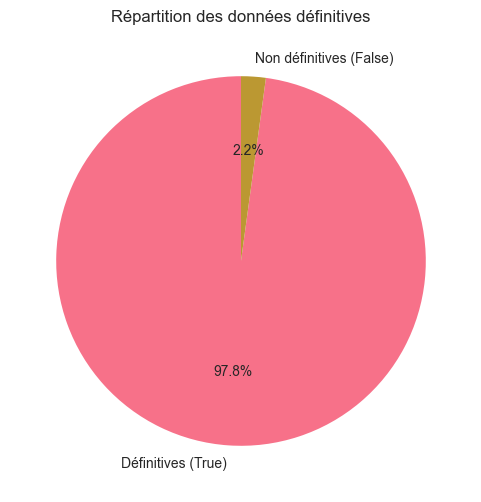

In [14]:
feature_name = "donnees_definitives"

total = len(df)
true_count = (df[feature_name] == True).sum()
false_count = (df[feature_name] == False).sum()

sizes = [true_count, false_count]
labels = ['Définitives (True)', 'Non définitives (False)']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des données définitives")
plt.show()

### Nettoyage des données 

In [15]:
count_passager_bo_null = (df['Number of Boarding Passengers'] == 0).sum()
print(f"Nombre de passagers montant avec valeur 0 : {count_passager_bo_null}")
count_passager_Di_null = (df['Number of Disembarking Passengers'] == 0).sum()
print(f"Nombre de passagers descendant avec valeur 0 : {count_passager_Di_null}")

Nombre de passagers montant avec valeur 0 : 356
Nombre de passagers descendant avec valeur 0 : 318


In [16]:
# Filtrer uniquement les données définitives
df = df[~(df['donnees_definitives'] == False)].copy()
print(f"Données après filtrage des données non définitives : {df.shape}")
print(df['donnees_definitives'].value_counts())

Données après filtrage des données non définitives : (56668, 10)
donnees_definitives
True    56668
Name: count, dtype: int64


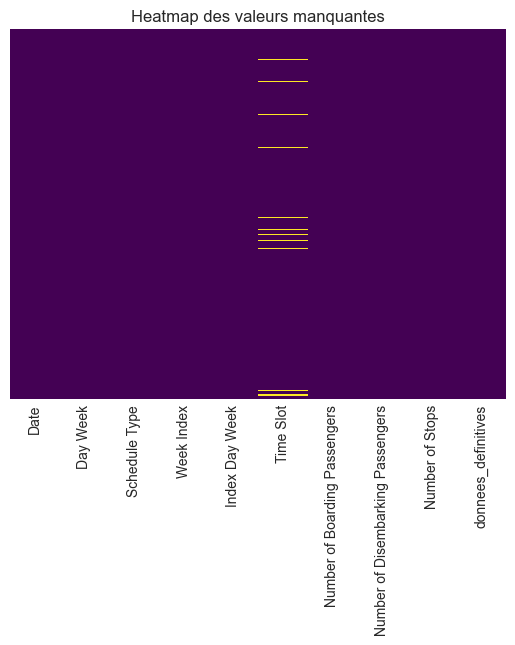

In [17]:
# Heatmap des valeurs manquantes
plt.figure()
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Heatmap des valeurs manquantes")
plt.show()

La heatmap montre que ton dataset contient presque aucune valeur manquante, la plupart des colonnes sont complètes (violettes), avec seulement quelques valeurs isolées manquantes dans la colonne Time Slot

In [18]:
# Remplacer les "-" par NaN dans Time Slot
df['Time Slot'] = df['Time Slot'].replace("-", np.nan)
print(f"Valeurs manquantes après traitement Time Slot :")
print(df.isna().sum())

Valeurs manquantes après traitement Time Slot :
Date                                    0
Day Week                                0
Schedule Type                           0
Week Index                              0
Index Day Week                          0
Time Slot                            1823
Number of Boarding Passengers           0
Number of Disembarking Passengers       0
Number of Stops                         0
donnees_definitives                     0
dtype: int64


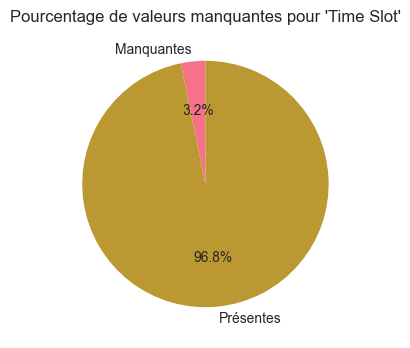

In [19]:
feature_name = "Time Slot"  

total = len(df)
missing = df[feature_name].isnull().sum()
present = total - missing

sizes = [missing, present]
labels = ['Manquantes', 'Présentes']

# Plot
plt.figure(figsize=(6,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(f"Pourcentage de valeurs manquantes pour '{feature_name}'")
plt.show()


In [20]:
df = df[~(df['Time Slot'].isna())].copy()
print(f"Données après suppression des Time Slot manquants : {df.shape}")

Données après suppression des Time Slot manquants : (54845, 10)


In [21]:
df["Day Week"].head()

0    4-Jeudi
1    4-Jeudi
2    4-Jeudi
3    4-Jeudi
4    4-Jeudi
Name: Day Week, dtype: object

In [22]:
df["Day Week"] = df["Day Week"].str.split("-").str[1]

In [23]:
df["Day Week"].head()

0    Jeudi
1    Jeudi
2    Jeudi
3    Jeudi
4    Jeudi
Name: Day Week, dtype: object

### Transformation Des Types De Données 

In [24]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Day Week"] = df["Day Week"].astype("category")
df["Schedule Type"] = df["Schedule Type"].astype("category")
df["Week Index"] = df["Week Index"].astype("int8")
df["Index Day Week"] = df["Index Day Week"].astype("uint8")
df["Time Slot"] = df["Time Slot"].astype("int8")
df['Number of Boarding Passengers'] = df['Number of Boarding Passengers'].fillna(0).astype(int)
df['Number of Disembarking Passengers'] = df['Number of Disembarking Passengers'].fillna(0).astype(int)

In [25]:
df.dtypes

Date                                 datetime64[ns]
Day Week                                   category
Schedule Type                              category
Week Index                                     int8
Index Day Week                                uint8
Time Slot                                      int8
Number of Boarding Passengers                 int64
Number of Disembarking Passengers             int64
Number of Stops                               int64
donnees_definitives                            bool
dtype: object

In [26]:
nb_invalid_dates = df['Date'].isna().sum()
print(f"Nombre de dates invalides : {nb_invalid_dates}")

Nombre de dates invalides : 0


###  Vérification De Cohérence Des Données 

Cette section vérifie la cohérence entre plusieurs colonnes: la date, le jour, leur index, le type d’horaire et l’index de semaine  pour s’assurer que les données sont logiques et correctes.

In [27]:
# Vérifier la cohérence entre Day Week et Index Day Week
day_to_index = {
    'Lundi': 1, 'Mardi': 2, 'Mercredi': 3, 'Jeudi': 4,
    'Vendredi': 5, 'Samedi': 6, 'Dimanche': 7
}

coherent_mask = df.apply(
    lambda row: row['Index Day Week'] == day_to_index.get(row['Day Week'], 0),
    axis=1
)

nb_coherent = coherent_mask.sum()
nb_incoherent = len(coherent_mask) - nb_coherent
print(f"Lignes cohérentes (Day Week vs Index) : {nb_coherent}")
print(f"Lignes incohérentes (Day Week vs Index) : {nb_incoherent}")

Lignes cohérentes (Day Week vs Index) : 54845
Lignes incohérentes (Day Week vs Index) : 0


In [28]:
# Vérifier la cohérence entre Date et Day Week
day_to_weekday = {
    'Lundi': 0, 'Mardi': 1, 'Mercredi': 2, 'Jeudi': 3,
    'Vendredi': 4, 'Samedi': 5, 'Dimanche': 6
}

date_coherent_mask = df.apply(
    lambda row: pd.notna(row['Date']) and row['Date'].weekday() == day_to_weekday.get(row['Day Week'], -1),
    axis=1
)

nb_date_coherent = date_coherent_mask.sum()
nb_date_incoherent = len(date_coherent_mask) - nb_date_coherent
print(f"Lignes cohérentes (Date vs Day Week) : {nb_date_coherent}")
print(f"Lignes incohérentes (Date vs Day Week) : {nb_date_incoherent}")

Lignes cohérentes (Date vs Day Week) : 54845
Lignes incohérentes (Date vs Day Week) : 0


In [29]:
# Vérification de cohérence entre Schedule Type et Index Day Week
def coherence_check(row):
    sched = str(row["Schedule Type"]).upper()
    if (sched == "DIMANCHE" and row["Index Day Week"] != 7) \
       or (sched == "SAMEDI" and row["Index Day Week"] != 6) \
       or (sched == "NORMAL" and row["Index Day Week"] in [6, 7]):
        return False
    return True

coherent_mask = df.apply(coherence_check, axis=1)
incoherent_rows = df[~coherent_mask]
print(f"Nombre de lignes incohérentes (Schedule vs Index) : {len(incoherent_rows)}")
if len(incoherent_rows) > 0:
    print(incoherent_rows[["Day Week", "Index Day Week", "Schedule Type"]].head(20))

Nombre de lignes incohérentes (Schedule vs Index) : 1145
     Day Week  Index Day Week Schedule Type
308     Jeudi               4      DIMANCHE
309     Jeudi               4      DIMANCHE
310     Jeudi               4      DIMANCHE
364     Lundi               1      DIMANCHE
365     Lundi               1      DIMANCHE
366     Lundi               1      DIMANCHE
367     Lundi               1      DIMANCHE
368     Lundi               1      DIMANCHE
673  Vendredi               5      DIMANCHE
674  Vendredi               5      DIMANCHE
675  Vendredi               5      DIMANCHE
676  Vendredi               5      DIMANCHE
677  Vendredi               5      DIMANCHE
678  Vendredi               5      DIMANCHE
679  Vendredi               5      DIMANCHE
937  Mercredi               3      DIMANCHE
938  Mercredi               3      DIMANCHE
939  Mercredi               3      DIMANCHE
940  Mercredi               3      DIMANCHE
941  Mercredi               3      DIMANCHE


###  Features Engineering 

-Suppression de colonnes : **donnees_definitives** (inutile pour le modèle) et **Number of Disembarking Passengers** (fortement corrélée avec la cible, créant un data leakage).

-Schedule Type : création du type de jour à partir de la date pour distinguer jours normaux, week-ends et périodes de vacances (ex. vacances scolaires, fêtes, etc.).

-Jour, Mois, Année : extraction depuis la colonne Date pour faciliter filtrage, regroupement et analyse des données.

In [30]:
# Supprimer l'ancienne colonne Schedule Type
if 'Schedule Type' in df.columns:
    df.drop(columns=['Schedule Type'], inplace=True)


In [31]:
#les vacances scolaires Genève 2019-2025
vacances_geneve = [
    # 2019
    ("2019-10-19", "2019-11-03"), ("2019-12-21", "2020-01-05"),
    # 2020
    ("2020-02-15", "2020-02-23"), ("2020-04-04", "2020-04-19"),
    ("2020-07-04", "2020-08-16"), ("2020-10-10", "2020-10-25"),
    ("2020-12-19", "2021-01-03"),
    # 2021
    ("2021-02-13", "2021-02-21"), ("2021-04-03", "2021-04-18"),
    ("2021-07-03", "2021-08-15"), ("2021-10-09", "2021-10-24"),
    ("2021-12-18", "2022-01-02"),
    # 2022
    ("2022-02-12", "2022-02-20"), ("2022-04-02", "2022-04-17"),
    ("2022-07-02", "2022-08-14"), ("2022-10-08", "2022-10-23"),
    ("2022-12-17", "2023-01-01"),
    # 2023
    ("2023-02-18", "2023-02-26"), ("2023-04-08", "2023-04-23"),
    ("2023-07-01", "2023-08-13"), ("2023-10-07", "2023-10-22"),
    ("2023-12-23", "2024-01-07"),
    # 2024
    ("2024-02-10", "2024-02-18"), ("2024-04-06", "2024-04-21"),
    ("2024-07-06", "2024-08-18"), ("2024-10-12", "2024-10-27"),
    ("2024-12-21", "2025-01-05"),
    # 2025
    ("2025-02-08", "2025-02-16"), ("2025-04-05", "2025-04-20"),
    ("2025-07-05", "2025-08-17"), ("2025-10-11", "2025-10-26"),
    ("2025-12-20", "2026-01-04")
]

vac_ranges = [(pd.to_datetime(s), pd.to_datetime(e)) for s, e in vacances_geneve]

# les jours fériés suisses
years = df['Date'].dt.year.dropna().unique()
swiss_holidays = holidays.Switzerland(years=years, prov='GE')


In [32]:
# Fonction pour déterminer le type de jour
def determine_day_type(row):
    date = row['Date']
    if pd.isna(date):
        return "NORMAL"
    if date in swiss_holidays:
        return "VACANCES"
    for start, end in vac_ranges:
        if start <= date <= end:
            return "VACANCES"
    wd = date.weekday()
    if wd == 5:
        return "SAMEDI"
    if wd == 6:
        return "DIMANCHE"
    return "NORMAL"

In [33]:
df['Schedule Type'] = df.apply(determine_day_type, axis=1)
print("Nouvelle distribution de Schedule Type :")
print(df['Schedule Type'].value_counts())

Nouvelle distribution de Schedule Type :
Schedule Type
NORMAL      29512
VACANCES    14357
SAMEDI       5685
DIMANCHE     5291
Name: count, dtype: int64


In [34]:
# Extraction de features temporelles
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [35]:
df["Schedule Type"] = df["Schedule Type"].astype("category")

#### Data leakage

In [36]:
num_cols = df.select_dtypes(include=[np.number]).columns

correlations = df[num_cols].corrwith(df['Number of Boarding Passengers']).abs().sort_values(ascending=False)

print("Corrélations avec la cible par ordre décroissant :")
print(correlations)


Corrélations avec la cible par ordre décroissant :
Number of Boarding Passengers        1.000000
Number of Disembarking Passengers    0.996157
Number of Stops                      0.892296
Time Slot                            0.290934
Index Day Week                       0.263849
Year                                 0.083621
Month                                0.009450
Week Index                           0.008800
Day                                  0.004096
dtype: float64


La variable Number of Disembarking Passengers présente une corrélation très élevée avec la variable cible (0.996). Cela signifie qu’elle apporte presque exactement la même information que la cible. Comme cette variable est mesurée au même moment que Number of Boarding Passengers, elle révèle indirectement la valeur que l’on cherche à prédire. Dans ce cas, son utilisation crée une situation de data leakage, car le modèle apprend une information qu’il n’est pas censé connaître au moment de la prédiction réelle. Donc on doit la supprimer.

In [37]:
df = df.drop(columns=['Number of Disembarking Passengers'])

In [38]:
df = df.drop(columns=['donnees_definitives'])

### Visualisations Exploratoires

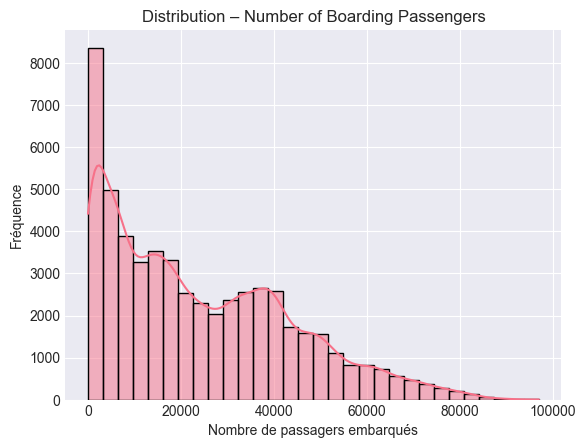

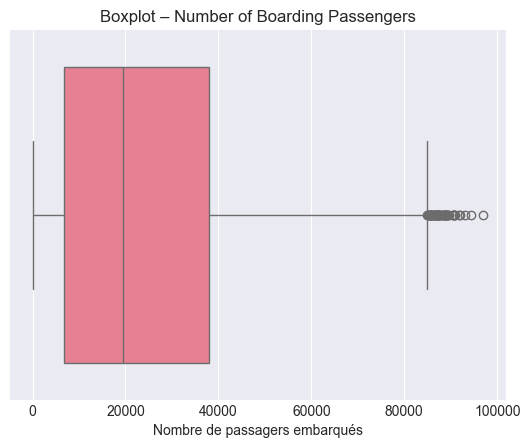

In [39]:
# Distribution des passagers embarqués
plt.figure()
sns.histplot(df['Number of Boarding Passengers'], bins=30, kde=True)
plt.title("Distribution – Number of Boarding Passengers")
plt.xlabel("Nombre de passagers embarqués")
plt.ylabel("Fréquence")
plt.show()

# Boxplot des passagers embarqués
plt.figure()
sns.boxplot(x=df['Number of Boarding Passengers'])
plt.title("Boxplot – Number of Boarding Passengers")
plt.xlabel("Nombre de passagers embarqués")
plt.show()

#### Histogramme – Distribution des passagers montants

La plupart des transports transportent peu ou moyennement de passagers (0–40 000). La distribution est asymétrique à droite, avec quelques jours exceptionnellement chargés (70 000–100 000). Les fréquences diminuent progressivement pour les valeurs élevées.
#### Boxplot – Dispersion et outliers
Le boxplot confirme l’asymétrie : la médiane est basse, la boîte est large, et de nombreux outliers apparaissent vers les valeurs élevées. Cela reflète des journées avec un trafic très important par rapport à la majorité des vols.
#### Conclusion 
Le trafic des passagers montants est majoritairement faible à moyen, avec quelques pics exceptionnels, rendant la distribution très irrégulière.

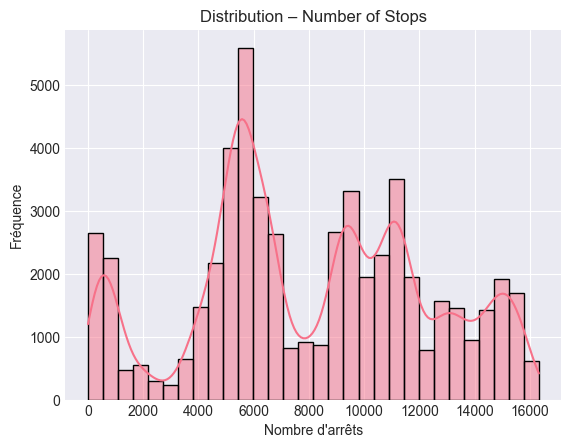

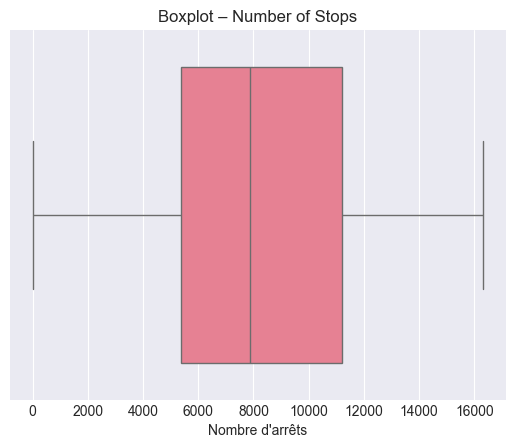

In [40]:
# Distribution du nombre d'arrêts
plt.figure()
sns.histplot(df['Number of Stops'], bins=30, kde=True)
plt.title("Distribution – Number of Stops")
plt.xlabel("Nombre d'arrêts")
plt.ylabel("Fréquence")
plt.show()

# Boxplot du nombre d'arrêts
plt.figure()
sns.boxplot(x=df['Number of Stops'])
plt.title("Boxplot – Number of Stops")
plt.xlabel("Nombre d'arrêts")
plt.show()

#### Histogramme (Distribution)
L’histogramme montre une distribution étendue du nombre d’arrêts, avec des valeurs allant approximativement de 0 à 16 500 arrêts. On observe plusieurs pics, ce qui suggère une distribution multimodale. 
#### Boxplot
Le rectangle du boxplot s’étend d’environ 5 000 à 11 000, avec une médiane proche de 8 000, ce qui montre que la majorité des lignes se situe dans cette plage. La dispersion est large, mais il n’y a pas de points isolés clairement définis comme outliers.
#### Conclusion
La distribution et le boxplot montrent que la variable est très variée avec une large plage de valeurs, mais aucun outlier strict n’est détecté.

###  Analayse De Tendance Et Relation

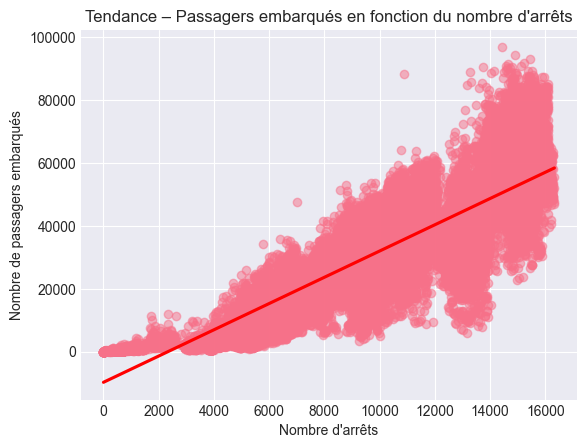

In [41]:
# Passagers embarqués vs Nombre d'arrêts
plt.figure()
sns.regplot(x='Number of Stops', y='Number of Boarding Passengers', 
            data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Tendance – Passagers embarqués en fonction du nombre d'arrêts")
plt.xlabel("Nombre d'arrêts")
plt.ylabel("Nombre de passagers embarqués")
plt.show()

Le graphique montre une relation positive : plus le nombre d’arrêts augmente, plus le nombre de passagers débarqués tend à être élevé.

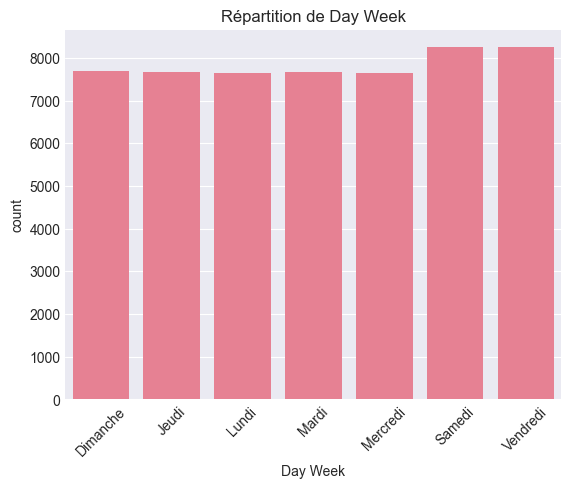

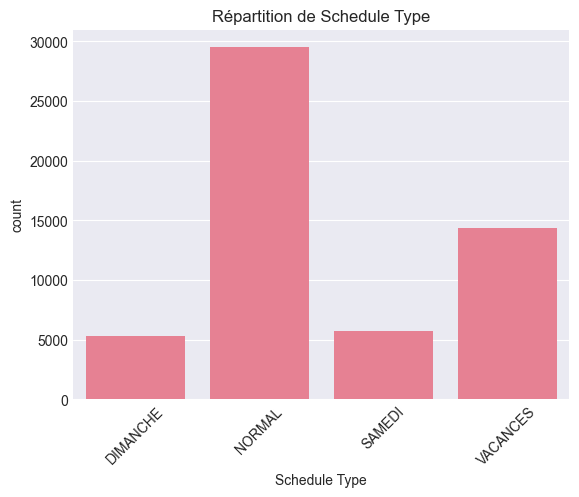

In [42]:
# Répartition par jour de la semaine
cat_cols = ['Day Week', 'Schedule Type']
for col in cat_cols:
    plt.figure()
    sns.countplot(x=col, data=df)
    plt.title(f"Répartition de {col}")
    plt.xticks(rotation=45)
    plt.show()

#### Jour de la semaine
La répartition est globalement équilibrée, avec un léger pic vendredi et samedi et le point le plus bas mercredi.
#### Schedule Type
La majorité des observations est NORMAL, suivie par VACANCES, tandis que SAMEDI et DIMANCHE sont beaucoup moins fréquents.

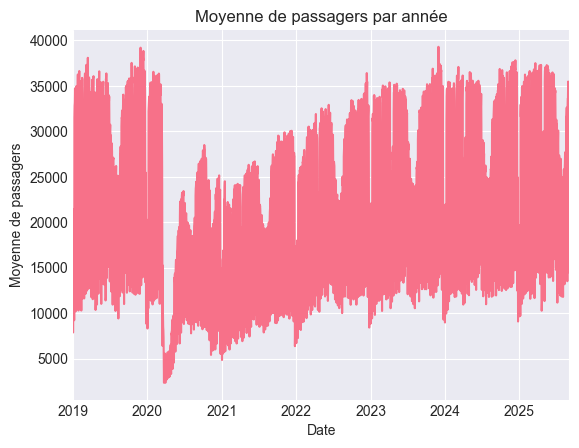

In [43]:
# Nombre total de passagers par jour
plt.figure()
df.groupby('Date')['Number of Boarding Passengers'].mean().plot()
plt.title("Moyenne de passagers par année")
plt.xlabel("Date")
plt.ylabel("Moyenne de passagers")
plt.show()

#### Analyse du graphique 
On remarque une chute significative autour de 2020 (COVID-19), suivie d’une reprise progressive , avec des variations régulières reflétant la saisonnalité et les fluctuations quotidiennes


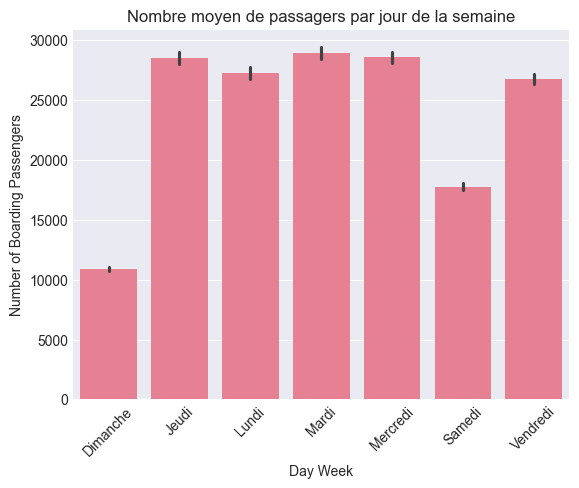

In [44]:
# Moyenne de passagers par jour de la semaine
plt.figure()
sns.barplot(x='Day Week', y='Number of Boarding Passengers', data=df, estimator=np.mean)
plt.title("Nombre moyen de passagers par jour de la semaine")
plt.xticks(rotation=45)
plt.show()

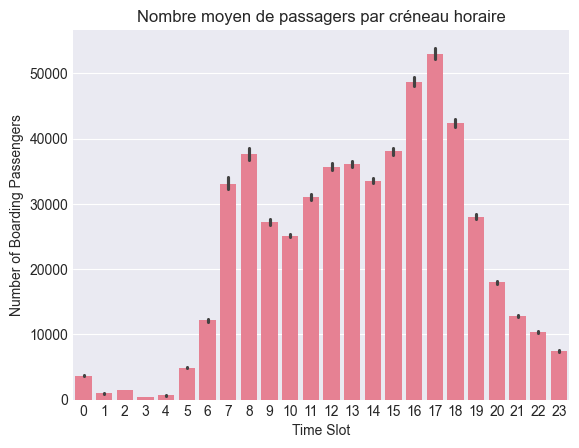

In [45]:
# Moyenne de passagers par créneau horaire
plt.figure()
sns.barplot(x='Time Slot', y='Number of Boarding Passengers', data=df, estimator=np.mean)
plt.title("Nombre moyen de passagers par créneau horaire")
plt.show()

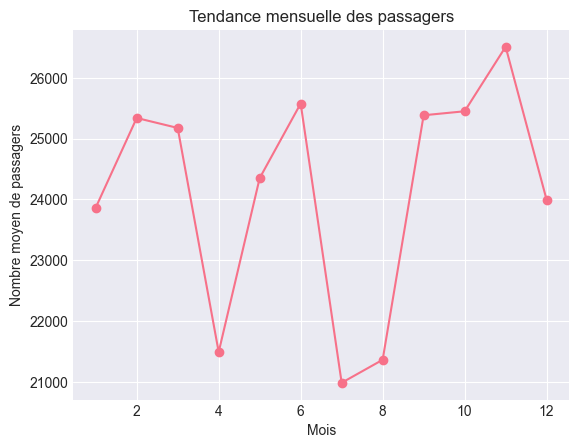

In [46]:
# Tendance mensuelle des passagers
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Number of Boarding Passengers'].mean()
plt.figure()
monthly_avg.plot(marker='o')
plt.title("Tendance mensuelle des passagers")
plt.xlabel("Mois")
plt.ylabel("Nombre moyen de passagers")
plt.grid(True)
plt.show()

La fréquentation varie **au cours de l’année**, avec des **pics en juin et octobre-novembre** et des **creux en avril et juillet**, reflétant une **saisonnalité claire** et des comportements liés aux vacances et activités saisonnières, avec une variabilité modérée d’environ 5 000 passagers.


### Corrélation entre les features 

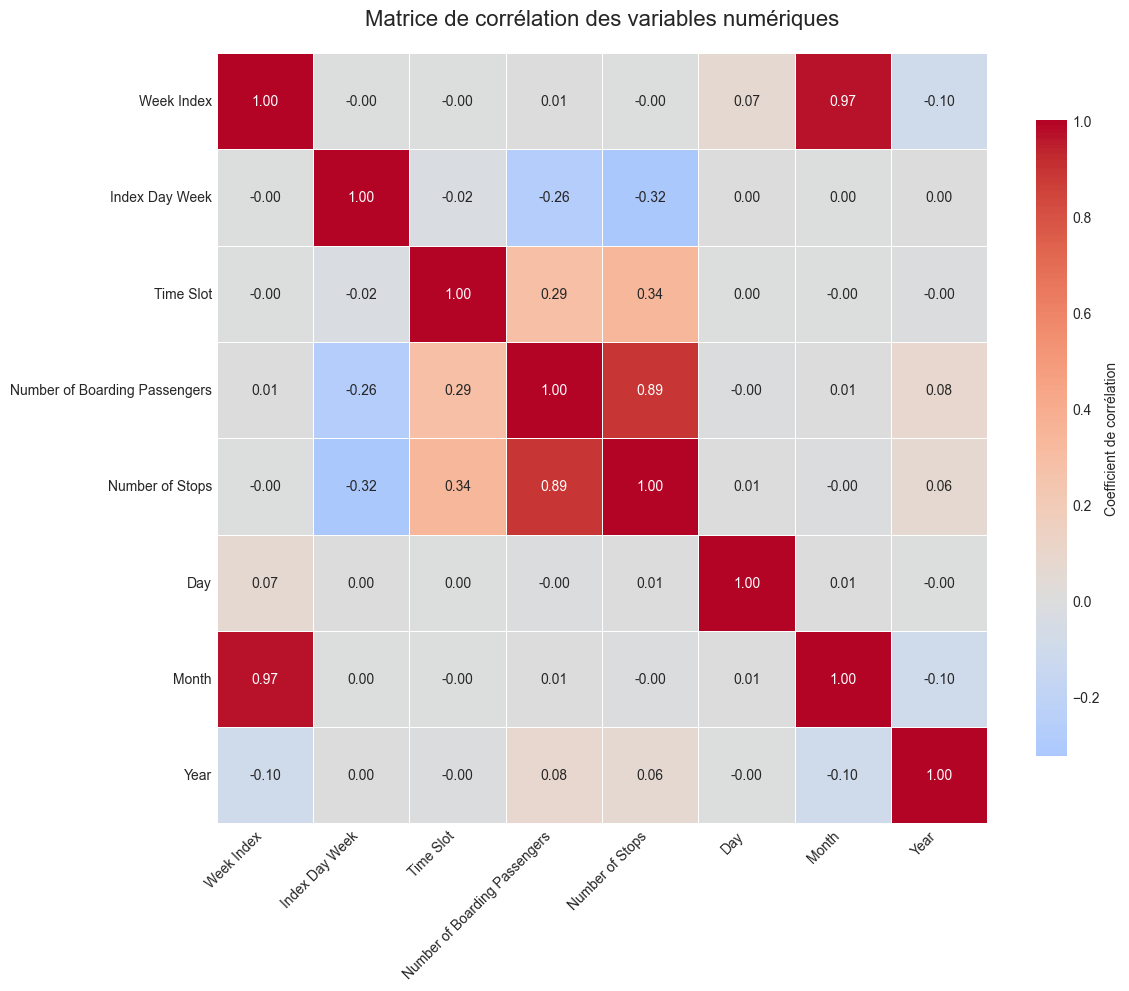

In [47]:
numeric_cols = df.select_dtypes(include='number')

# Calculer la matrice de corrélation
corr_matrix = numeric_cols.corr()

# Créer la figure
plt.figure(figsize=(12, 10))

# Créer la heatmap
sns.heatmap(
    corr_matrix,
    annot=True,  
    fmt='.2f',  
    cmap='coolwarm',  
    center=0,   
    square=True,
    linewidths=0.5, 
    cbar_kws={'shrink': 0.8, 'label': 'Coefficient de corrélation'}
)

plt.title("Matrice de corrélation des variables numériques", 
          fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



On observe que seules certaines variables présentent une relation significative(comme Number of Stops ), tandis que d’autres ont une corrélation faible ou nulle et n’apportent pas d’information pertinente pour la prédiction.

In [48]:
df.shape

(54845, 11)

In [49]:
df.columns

Index(['Date', 'Day Week', 'Week Index', 'Index Day Week', 'Time Slot',
       'Number of Boarding Passengers', 'Number of Stops', 'Schedule Type',
       'Day', 'Month', 'Year'],
      dtype='object')

In [50]:
df.dtypes

Date                             datetime64[ns]
Day Week                               category
Week Index                                 int8
Index Day Week                            uint8
Time Slot                                  int8
Number of Boarding Passengers             int64
Number of Stops                           int64
Schedule Type                          category
Day                                       int32
Month                                     int32
Year                                      int32
dtype: object

In [51]:
df[['Number of Stops', 'Number of Boarding Passengers']].describe()

,Number of Stops,Number of Boarding Passengers
count,54845.000000,54845.000000
mean,8097.432090,24046.021661
std,4210.510165,19724.355965
min,1.000000,0.000000
25%,5364.000000,6679.000000
50%,7866.000000,19449.000000
75%,11219.000000,37988.000000
max,16329.000000,97043.000000


In [52]:
nb_invalid_dates = df['Date'].isna().sum()
print(f"Nombre de dates invalides : {nb_invalid_dates}")

Nombre de dates invalides : 0


###  Sauvegarde des données nettoyées

In [53]:
df.to_pickle("clean_data/rider_ship_clean.pkl")

In [54]:
df.to_csv("clean_data/rider_ship_clean.csv")

In [55]:
print(f"Dataset nettoyé sauvegardé avec {df.shape[0]} lignes et {df.shape[1]} colonnes")

Dataset nettoyé sauvegardé avec 54845 lignes et 11 colonnes


## Entraînement et Évaluation des Modèles
Les modèles Random Forest et Gradient Boosting (LightGBM / XGBoost) sont entraînés pour prédire le nombre de passagers, puis évalués à l’aide de métriques de performance afin de comparer leurs résultats.

### Chargement et Préparation des Données

In [56]:
df = pd.read_pickle("clean_data/rider_ship_clean.pkl")
df.head()

,Date,Day Week,Week Index,Index Day Week,Time Slot,Number of Boarding Passengers,Number of Stops,Schedule Type,Day,Month,Year
0,2022-12-01,Jeudi,48,4,7,58042,14954,NORMAL,1,12,2022
1,2022-12-01,Jeudi,48,4,12,47433,11464,NORMAL,1,12,2022
2,2022-12-01,Jeudi,48,4,14,39346,10878,NORMAL,1,12,2022
3,2022-12-01,Jeudi,48,4,19,37301,12947,NORMAL,1,12,2022
4,2022-12-01,Jeudi,48,4,10,31429,10947,NORMAL,1,12,2022


In [57]:
# features and target
y = df["Number of Boarding Passengers"] 
X = df.drop(columns=["Number of Boarding Passengers", "Date"])

### Séparation Train/Test

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f" Taille Train: {X_train.shape}")
print(f" Taille Test:  {X_test.shape}")

print(f" Statistiques de la variable cible:")
print(f"  Moyenne: {y.mean():.2f} passagers")
print(f"  Min:     {y.min():.0f} passagers")
print(f"  Max:     {y.max():.0f} passagers")
print(f"  Écart-type: {y.std():.2f}")

 Taille Train: (43876, 9)
 Taille Test:  (10969, 9)
 Statistiques de la variable cible:
  Moyenne: 24046.02 passagers
  Min:     0 passagers
  Max:     97043 passagers
  Écart-type: 19724.36


### Modèles Baseline (Référence)

In [59]:
# Baseline 1: Prédire toujours la moyenne
baseline_mean = y_train.mean()
y_pred_baseline_mean = np.full(len(y_test), baseline_mean)

rmse_baseline_mean = np.sqrt(mean_squared_error(y_test, y_pred_baseline_mean))
mae_baseline_mean = mean_absolute_error(y_test, y_pred_baseline_mean)
r2_baseline_mean = r2_score(y_test, y_pred_baseline_mean)

print(f" Baseline (Moyenne = {baseline_mean:.2f}):")
print(f"   RMSE: {rmse_baseline_mean:.2f}")
print(f"   MAE:  {mae_baseline_mean:.2f}")
print(f"   R²:   {r2_baseline_mean:.4f}")

# Baseline 2: Prédire toujours la médiane
baseline_median = y_train.median()
y_pred_baseline_median = np.full(len(y_test), baseline_median)

rmse_baseline_median = np.sqrt(mean_squared_error(y_test, y_pred_baseline_median))
mae_baseline_median = mean_absolute_error(y_test, y_pred_baseline_median)
r2_baseline_median = r2_score(y_test, y_pred_baseline_median)

print(f"Baseline (Médiane = {baseline_median:.2f}):")
print(f"   RMSE: {rmse_baseline_median:.2f}")
print(f"   MAE:  {mae_baseline_median:.2f}")
print(f"   R²:   {r2_baseline_median:.4f}")

 Baseline (Moyenne = 24136.73):
   RMSE: 19642.24
   MAE:  16580.64
   R²:   -0.0005
Baseline (Médiane = 19574.00):
   RMSE: 20062.34
   MAE:  16172.12
   R²:   -0.0438


### Création des Pipelines de Preprocessing

In [60]:
categorical_cols = ['Day Week', 'Schedule Type']

numerical_cols = X.select_dtypes(include='number').columns.tolist()


In [61]:
# Préprocesseur commun pour RF et XGBoost (avec OneHotEncoding)
preprocess_ohe = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Pipeline Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_ohe),
    ('model', RandomForestRegressor(random_state=42))
])

# Pipeline XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocess_ohe),
    ('model', XGBRegressor(random_state=42))
])

# Pipeline LightGBM (gère les catégories nativement, pas besoin de OneHotEncoder)
lgb_pipeline = lgb.LGBMRegressor(random_state=42)

print(" Pipelines créés avec succès!")

 Pipelines créés avec succès!


### Entraînement des Modèles initiaux

#### Random forest

In [62]:
# Entraînement du modèle
rf_pipeline.fit(X_train, y_train)

# Prédictions
y_pred_train_rf = rf_pipeline.predict(X_train)
y_pred_test_rf = rf_pipeline.predict(X_test)

# Métriques
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)

r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

# Affichage des résultats
print(f"Train → RMSE: {rmse_train_rf:.2f} | MAE: {mae_train_rf:.2f} | R²: {r2_train_rf:.4f}")
print(f"Test  → RMSE: {rmse_test_rf:.2f} | MAE: {mae_test_rf:.2f} | R²: {r2_test_rf:.4f}")
print(f"Ratio Test/Train (RMSE): {rmse_test_rf / rmse_train_rf:.2f}")
print(f"Écart RMSE (test - train): {rmse_test_rf - rmse_train_rf:.2f}")

Train → RMSE: 735.99 | MAE: 414.39 | R²: 0.9986
Test  → RMSE: 1861.62 | MAE: 1079.94 | R²: 0.9910
Ratio Test/Train (RMSE): 2.53
Écart RMSE (test - train): 1125.63


#### XGBoost

In [63]:
xgb_pipeline.fit(X_train, y_train)

y_pred_train_xgb = xgb_pipeline.predict(X_train)
y_pred_test_xgb = xgb_pipeline.predict(X_test)

# Métriques
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print(f"Train → RMSE: {rmse_train_xgb:.2f}| MAE: {mae_train_xgb:.2f} |   R²: {r2_train_xgb:.4f}")
print(f"Test  → RMSE: {rmse_test_xgb:.2f} | MAE: {mae_test_xgb:.2f} | R²: {r2_test_xgb:.4f}")
print(f"Ratio Test/Train: {rmse_test_xgb/rmse_train_xgb:.2f}")
print(f"Écart RMSE (test - train): {rmse_test_xgb - rmse_train_xgb:.2f}")

Train → RMSE: 1394.84| MAE: 944.39 |   R²: 0.9950
Test  → RMSE: 1601.01 | MAE: 1064.62 | R²: 0.9934
Ratio Test/Train: 1.15
Écart RMSE (test - train): 206.17


####  LightGBM

In [64]:
# Entraînement du modèle
lgb_pipeline.fit(X_train, y_train)

# Prédictions
y_pred_train_lgb = lgb_pipeline.predict(X_train)
y_pred_test_lgb = lgb_pipeline.predict(X_test)

# Métriques
rmse_train_lgb = np.sqrt(mean_squared_error(y_train, y_pred_train_lgb))
rmse_test_lgb = np.sqrt(mean_squared_error(y_test, y_pred_test_lgb))

mae_train_lgb = mean_absolute_error(y_train, y_pred_train_lgb)
mae_test_lgb = mean_absolute_error(y_test, y_pred_test_lgb)

r2_train_lgb = r2_score(y_train, y_pred_train_lgb)
r2_test_lgb = r2_score(y_test, y_pred_test_lgb)

# Affichage des résultats
print(f"Train → RMSE: {rmse_train_lgb:.2f} | MAE: {mae_train_lgb:.2f} | R²: {r2_train_lgb:.4f}")
print(f"Test  → RMSE: {rmse_test_lgb:.2f} | MAE: {mae_test_lgb:.2f} | R²: {r2_test_lgb:.4f}")
print(f"Ratio Test/Train (RMSE): {rmse_test_lgb / rmse_train_lgb:.2f}")
print(f"Écart RMSE (test - train): {rmse_test_lgb - rmse_train_lgb:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 43876, number of used features: 9
[LightGBM] [Info] Start training from score 24136.729602
Train → RMSE: 2008.11 | MAE: 1346.91 | R²: 0.9897
Test  → RMSE: 2024.52 | MAE: 1378.21 | R²: 0.9894
Ratio Test/Train (RMSE): 1.01
Écart RMSE (test - train): 16.41


### Cross Validation

 Random Forest...
   RMSE moyen: 2096.38 (+/- 25.33)
 XGBoost...
   RMSE moyen: 1742.93 (+/- 28.01)
 LightGBM...
   RMSE moyen: 2114.50 (+/- 43.85)


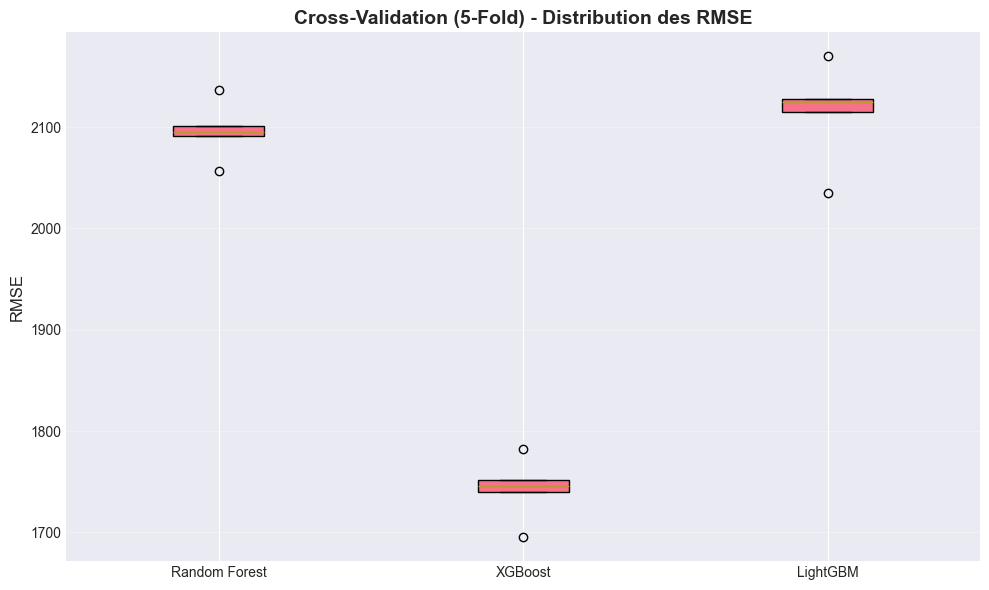

In [65]:
cv_models = [
    ('Random Forest', rf_pipeline),
    ('XGBoost', xgb_pipeline),
    ('LightGBM', lgb_pipeline)
]

cv_results = {}
for name, model in cv_models:
    print(f" {name}...")
    scores = cross_val_score(model, X_train, y_train, 
                            cv=5, 
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1)
    cv_results[name] = -scores
    print(f"   RMSE moyen: {-scores.mean():.2f} (+/- {scores.std():.2f})")

# Visualisation CV
plt.figure(figsize=(10, 6))
plt.boxplot([cv_results[name] for name in cv_results.keys()], 
            tick_labels=list(cv_results.keys()),
            patch_artist=True)
plt.ylabel('RMSE', fontsize=12)
plt.title('Cross-Validation (5-Fold) - Distribution des RMSE', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Lors de la cross-validation, XGBoost semble être le meilleur modèle avec un RMSE moyen de 1742 et une faible variabilité (±28), ce qui signifie qu’il prédit les passagers de manière précise et constante. Random Forest est très stable (±25) mais moins précis (RMSE 2096) et présente quelques validations atypiques, tandis que LightGBM est plus variable et moins fiable (RMSE 2114, ±44).

### Courbes d'apprentissage


 Random Forest...


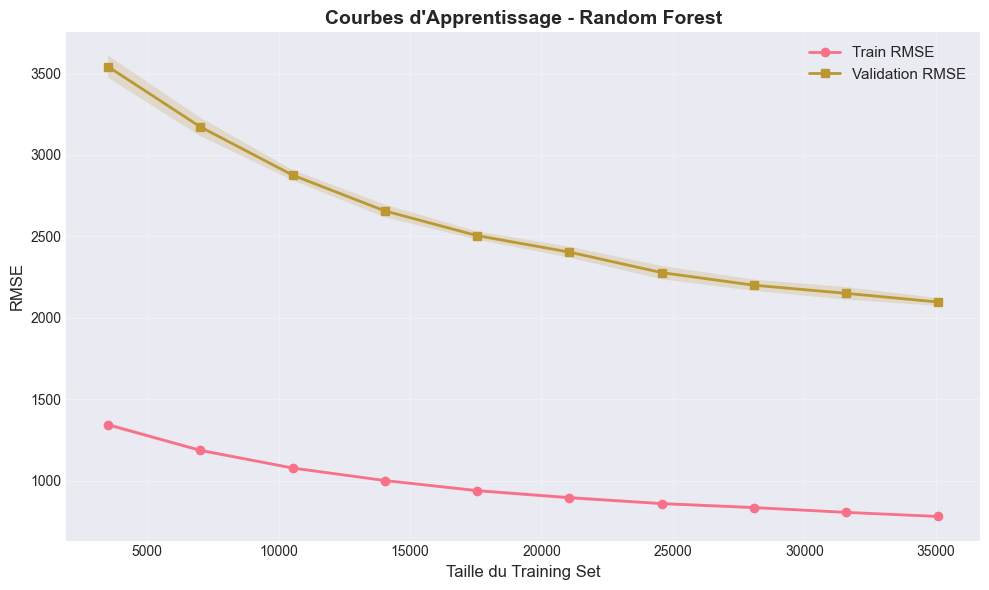

✓ Random Forest - RMSE final (Validation): 2096.52

 XGBoost...


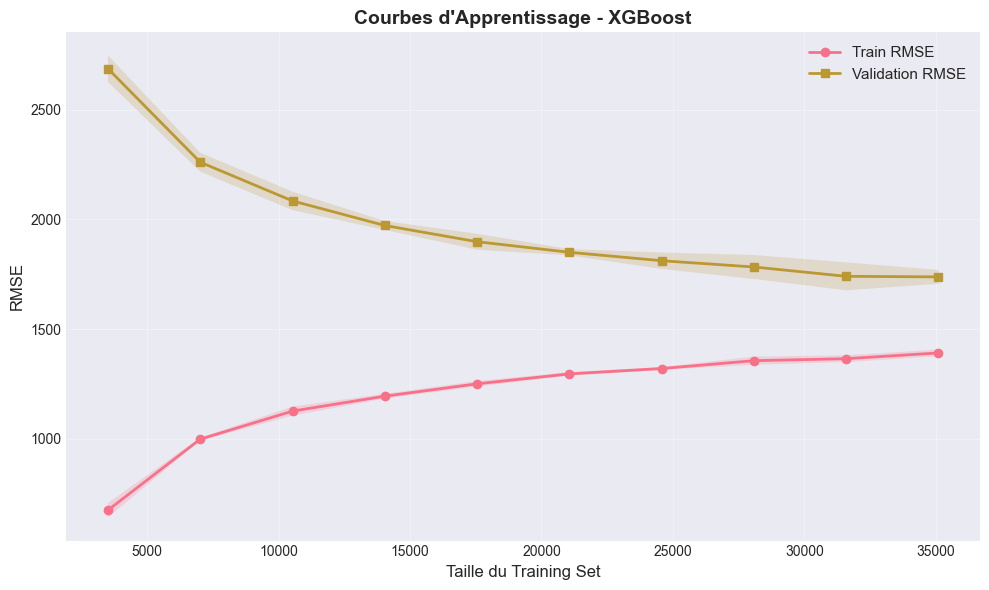

✓ XGBoost - RMSE final (Validation): 1737.66

 LightGBM...


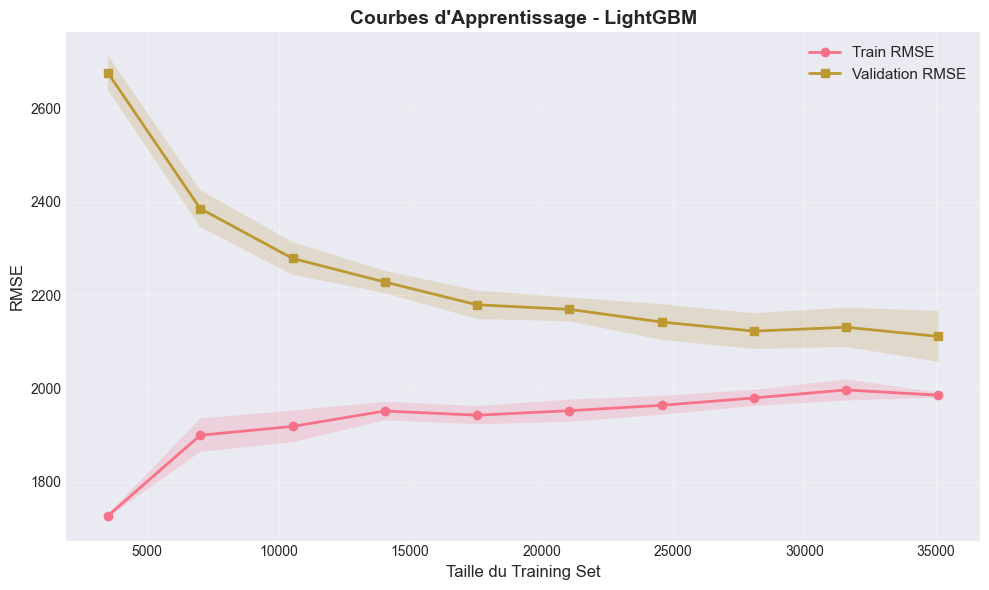

✓ LightGBM - RMSE final (Validation): 2111.49


In [66]:
def plot_learning_curves(model, model_name, X_train, y_train, categorical_cols=None):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    train_mean = -train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = -val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Train RMSE', marker='o', linewidth=2)
    plt.plot(train_sizes, val_mean, label='Validation RMSE', marker='s', linewidth=2)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
    
    plt.xlabel('Taille du Training Set', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title(f'Courbes d\'Apprentissage - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ {model_name} - RMSE final (Validation): {val_mean[-1]:.2f}")

print("\n Random Forest...")
plot_learning_curves(rf_pipeline, "Random Forest", X_train, y_train)

print("\n XGBoost...")
plot_learning_curves(xgb_pipeline, "XGBoost", X_train, y_train)

print("\n LightGBM...")
plot_learning_curves(lgb_pipeline, "LightGBM", X_train, y_train, categorical_cols=categorical_cols)


Les courbes d’apprentissage montrent que XGBoost reste le meilleur modèle avec une RMSE de validation finale autour de 1700 et un léger écart (~300) avec la RMSE d’entraînement, indiquant un overfitting modéré et une excellente généralisation. LightGBM présente un overfitting léger à modéré : la RMSE de validation (~2120) est plus élevée que XGBoost, mais l’écart avec le train (~140) reste acceptable et le modèle continue d’apprendre avec plus de données. Random Forest, en revanche, montre un overfitting sévère avec un écart énorme (~1350) entre train et validation, rendant ses prédictions peu fiables. Conclusion : XGBoost est recommandé pour ce projet, LightGBM pourrait être amélioré avec optimisation des hyperparamètres, et Random Forest est à éviter.

### Analyse des prédictions

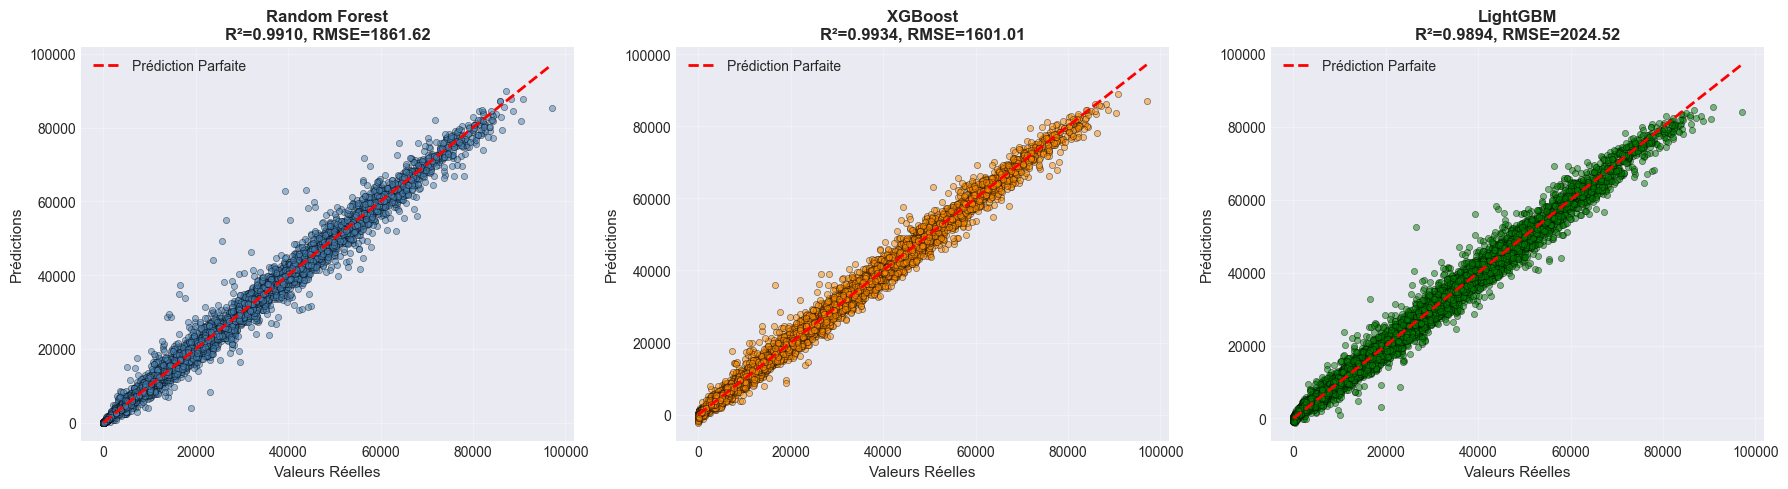

In [67]:
# Prédictions vs Valeurs Réelles
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Random Forest', y_pred_test_rf, 'steelblue'),
    ('XGBoost', y_pred_test_xgb, 'darkorange'),
    ('LightGBM', y_pred_test_lgb, 'green')
]

for idx, (name, y_pred, color) in enumerate(models):
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20, color=color, edgecolors='black', linewidth=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   'r--', lw=2, label='Prédiction Parfaite')
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    axes[idx].set_xlabel('Valeurs Réelles', fontsize=11)
    axes[idx].set_ylabel('Prédictions', fontsize=11)
    axes[idx].set_title(f'{name}\nR²={r2:.4f}, RMSE={rmse:.2f}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

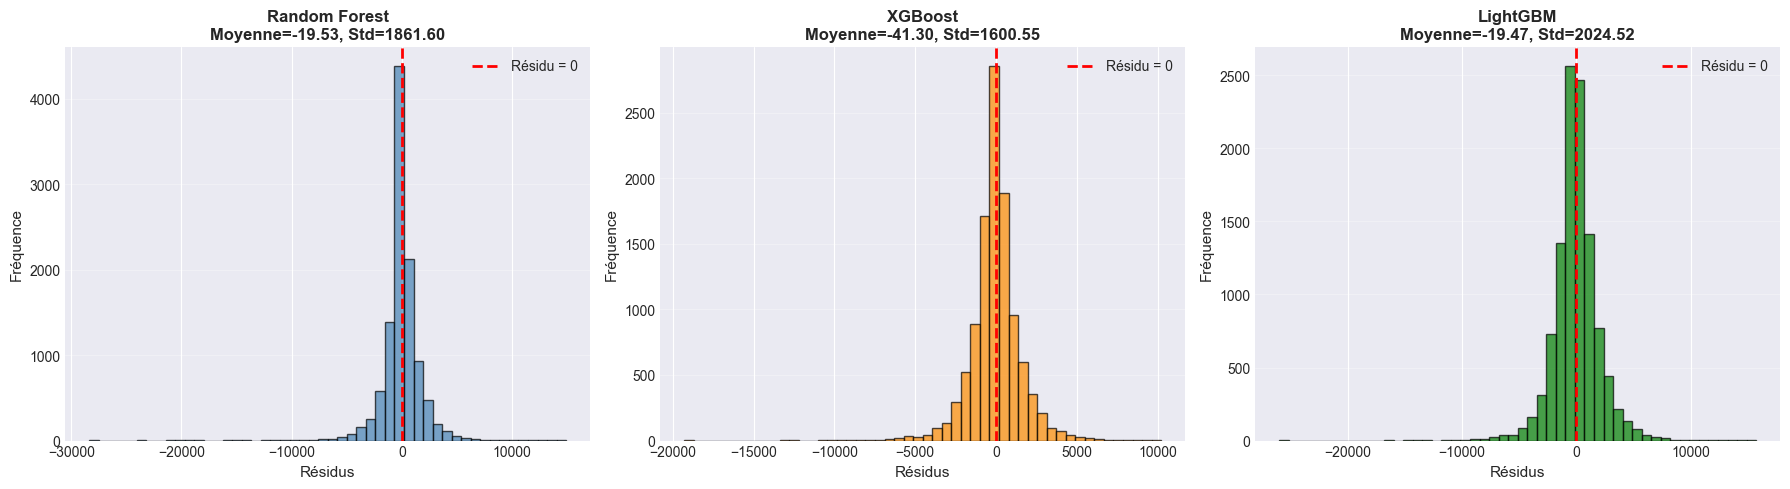

In [68]:
# Histogramme des Résidus
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, y_pred, color) in enumerate(models):
    residuals = y_test - y_pred
    
    axes[idx].hist(residuals, bins=50, color=color, alpha=0.7, edgecolor='black')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Résidu = 0')
    axes[idx].set_xlabel('Résidus', fontsize=11)
    axes[idx].set_ylabel('Fréquence', fontsize=11)
    axes[idx].set_title(f'{name}\nMoyenne={residuals.mean():.2f}, Std={residuals.std():.2f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Importance des features

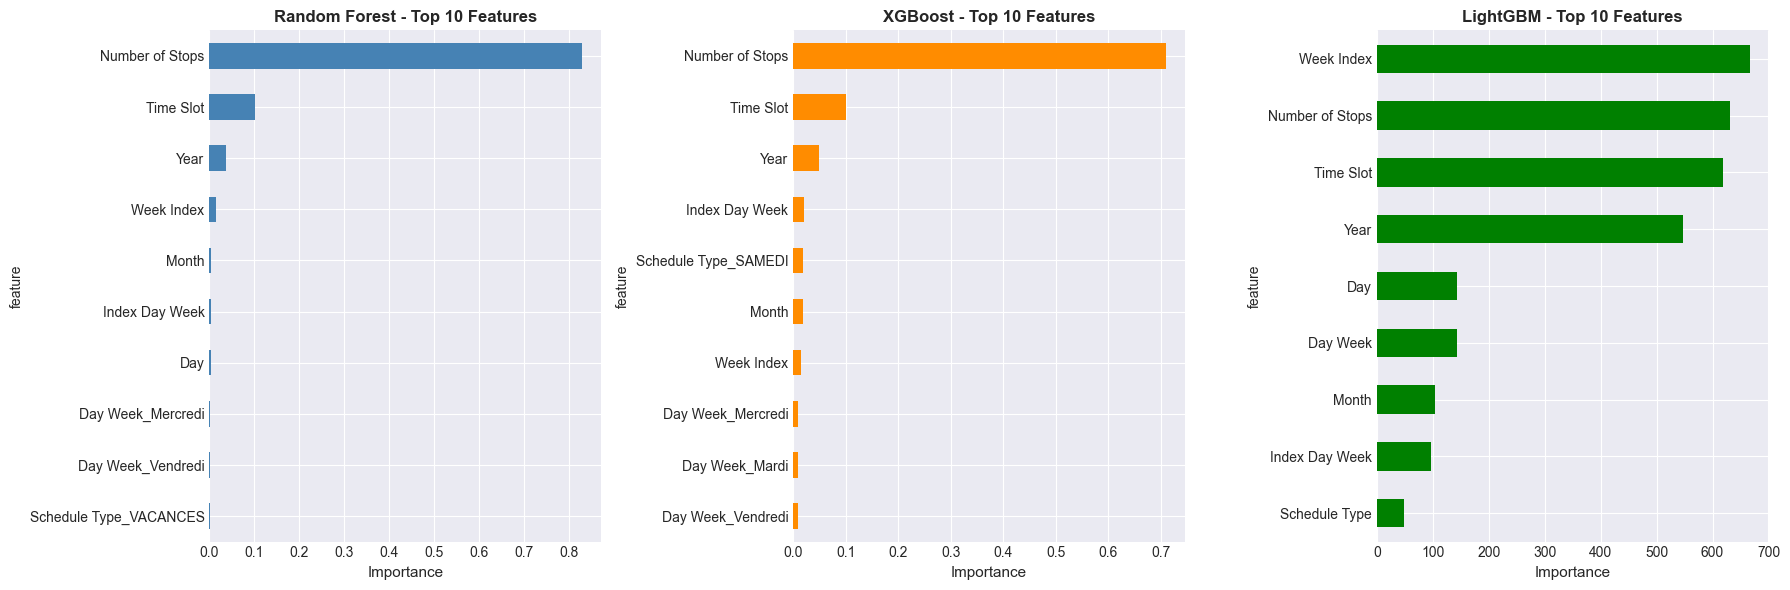

In [69]:
# Random Forest
ohe = rf_pipeline.named_steps['preprocess'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
rf_feature_names = ohe_feature_names + numerical_cols

rf_importances = rf_pipeline.named_steps['model'].feature_importances_
rf_feature_importance = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=False)

# XGBoost
xgb_importances = xgb_pipeline.named_steps['model'].feature_importances_
xgb_feature_importance = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': xgb_importances
}).sort_values('importance', ascending=False)

# LightGBM
lgb_importances = lgb_pipeline.feature_importances_
lgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns, 
    'importance': lgb_importances
}).sort_values('importance', ascending=False)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

rf_feature_importance.head(10).plot(kind='barh', x='feature', y='importance', 
                                    ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Random Forest - Top 10 Features', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].invert_yaxis()

xgb_feature_importance.head(10).plot(kind='barh', x='feature', y='importance', 
                                     ax=axes[1], color='darkorange', legend=False)
axes[1].set_title('XGBoost - Top 10 Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].invert_yaxis()

lgb_feature_importance.head(10).plot(kind='barh', x='feature', y='importance', 
                                     ax=axes[2], color='green', legend=False)
axes[2].set_title('LightGBM - Top 10 Features', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Importance', fontsize=11)
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()



In [70]:
print("\n Random Forest - Top 5:")
print(rf_feature_importance.head(5).to_string(index=False))

print("\n XGBoost - Top 5:")
print(xgb_feature_importance.head(5).to_string(index=False))

print("\n LightGBM - Top 5:")
print(lgb_feature_importance.head(5).to_string(index=False))


 Random Forest - Top 5:
        feature  importance
Number of Stops    0.830447
      Time Slot    0.102457
           Year    0.036885
     Week Index    0.014182
          Month    0.004483

 XGBoost - Top 5:
             feature  importance
     Number of Stops    0.710812
           Time Slot    0.100422
                Year    0.049417
      Index Day Week    0.020223
Schedule Type_SAMEDI    0.018341

 LightGBM - Top 5:
        feature  importance
     Week Index         667
Number of Stops         632
      Time Slot         619
           Year         548
            Day         144


### Comparaison des modéles

In [71]:
# Tableau récapitulatif
results = pd.DataFrame({
    'Model': ['Baseline (Moyenne)', 'Baseline (Médiane)', 'Random Forest', 'XGBoost', 'LightGBM'],
    'RMSE': [
        rmse_baseline_mean,
        rmse_baseline_median,
        rmse_test_rf,
        rmse_test_xgb,
        rmse_test_lgb
    ],
    'MAE': [
        mae_baseline_mean,
        mae_baseline_median,
        mae_test_rf,
        mae_test_xgb,
        mae_test_lgb
    ],
    'R²': [
        r2_baseline_mean,
        r2_baseline_median,
        r2_test_rf,
        r2_test_xgb,
        r2_test_lgb
    ]
})

print("\n Tableau Récapitulatif:")
print(results.to_string(index=False))



 Tableau Récapitulatif:
             Model         RMSE          MAE        R²
Baseline (Moyenne) 19642.240649 16580.642654 -0.000533
Baseline (Médiane) 20062.336880 16172.118151 -0.043789
     Random Forest  1861.622339  1079.935729  0.991013
           XGBoost  1601.009916  1064.622803  0.993353
          LightGBM  2024.519892  1378.212445  0.989371


In [72]:
# Meilleur modèle initial
ml_results = results[results['Model'].str.contains('Forest|XGBoost|LightGBM')]
best_model_idx = ml_results['RMSE'].idxmin()
best_model = ml_results.loc[best_model_idx]

print(f"\n MEILLEUR MODÈLE (Version Initiale): {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.2f}")
print(f"   MAE:  {best_model['MAE']:.2f}")
print(f"   R²:   {best_model['R²']:.4f}")

improvement = ((rmse_baseline_mean - best_model['RMSE']) / rmse_baseline_mean) * 100
print(f" Amélioration vs Baseline: {improvement:.2f}%")


 MEILLEUR MODÈLE (Version Initiale): XGBoost
   RMSE: 1601.01
   MAE:  1064.62
   R²:   0.9934
 Amélioration vs Baseline: 91.85%


### Optimisation des hyperparmetres

In [73]:
xgb_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.01, 0.1],
    'model__reg_lambda': [0, 0.01, 0.1]
}

lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}


In [74]:
# RandomizedSearchCV
print("\n Optimisation XGBoost...")
xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=20, cv=3,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1, random_state=42, verbose=1)
xgb_search.fit(X_train, y_train)

print("\n Optimisation LightGBM...")
lgb_search = RandomizedSearchCV(lgb_pipeline, lgb_params, n_iter=20, cv=3,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1, random_state=42, verbose=1)
lgb_search.fit(X_train, y_train, categorical_feature=categorical_cols)


 Optimisation XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Optimisation LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 43876, number of used features: 9
[LightGBM] [Info] Start training from score 24136.729602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,estimator,LGBMRegressor(random_state=42)
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'min_child_samples': [10, 20, ...], ...}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [75]:
# Meilleurs modèles
xgb_best = xgb_search.best_estimator_
lgb_best = lgb_search.best_estimator_

print("\n Optimisation terminée!")


 Optimisation terminée!


### Evaluation des modéles optimisés

In [76]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    return rmse_train, rmse_test, mae_test, r2_train, r2_test, y_pred_test

models = {
    'XGBoost': xgb_pipeline,
    'XGBoost Optimisé': xgb_best,
    'LightGBM': lgb_pipeline,
    'LightGBM Optimisé': lgb_best
}

performance = {}
for name, model in models.items():
    rmse_train, rmse_test, mae_test, r2_train, r2_test, y_pred_test = evaluate_model(
        model, X_train, y_train, X_test, y_test
    )
    performance[name] = {
        'RMSE_train': rmse_train, 
        'RMSE_test': rmse_test,
        'MAE_test': mae_test, 
        'R2_train': r2_train, 
        'R2_test': r2_test,
        'y_pred_test': y_pred_test
    }

perf_df = pd.DataFrame(performance).T
print("\n Performances avant/après optimisation:")
print(perf_df[['RMSE_test','MAE_test','R2_test']])


 Performances avant/après optimisation:
                     RMSE_test     MAE_test   R2_test
XGBoost            1601.009916  1064.622803  0.993353
XGBoost Optimisé   1547.016403  1015.631165  0.993794
LightGBM           2024.519892  1378.212445  0.989371
LightGBM Optimisé  1524.600778  1014.938579  0.993972


### Visualisation finales

In [77]:
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Valeurs Réelles', fontsize=12)
    plt.ylabel('Prédictions', fontsize=12)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [78]:
def plot_residuals(y_true, y_pred, title):
    resid = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, resid, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--', lw=2)
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Résidus', fontsize=12)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

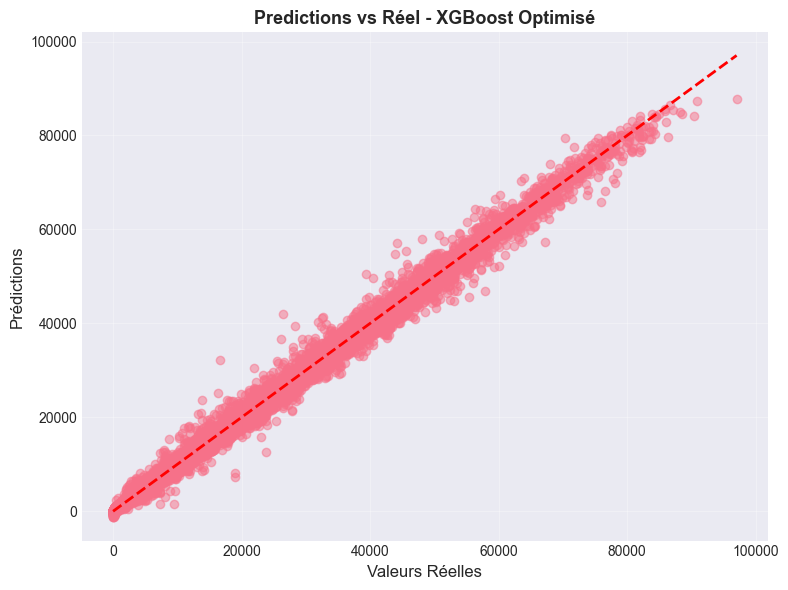

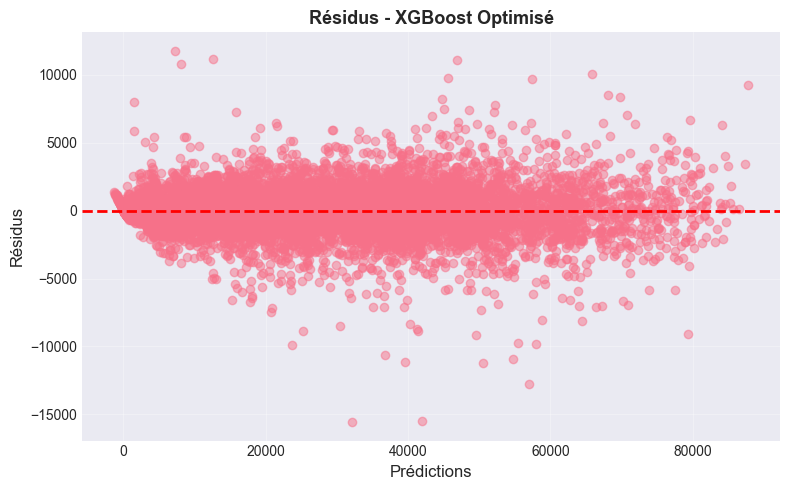

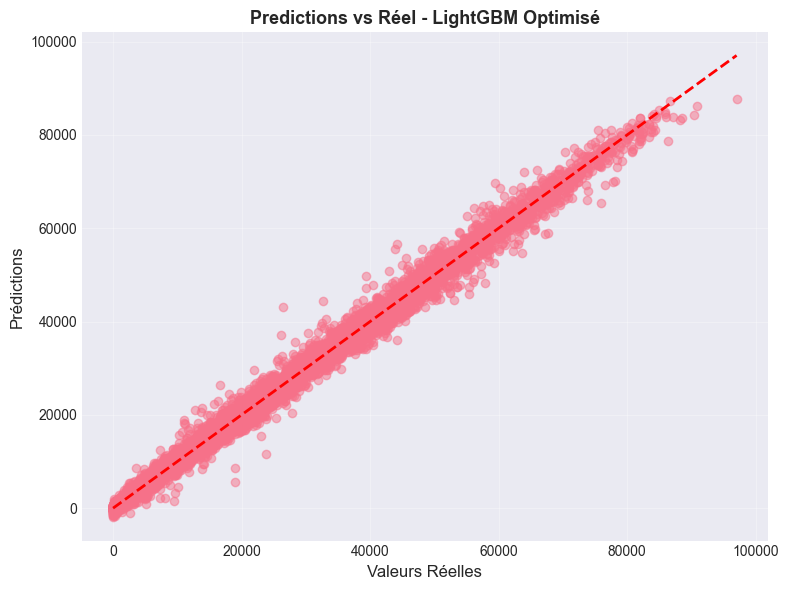

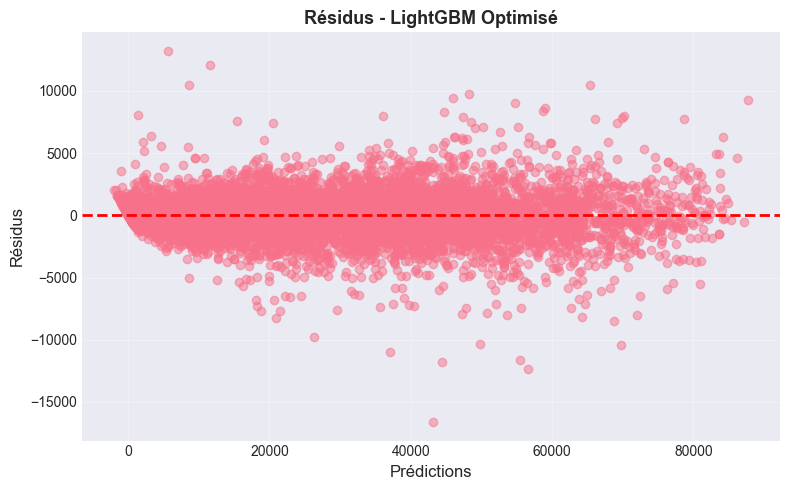

In [79]:
for name in ['XGBoost Optimisé','LightGBM Optimisé']:
    y_pred = performance[name]['y_pred_test']
    plot_pred_vs_actual(y_test, y_pred, f'Predictions vs Réel - {name}')
    plot_residuals(y_test, y_pred, f'Résidus - {name}')

### Meilleur modéle

In [80]:
best_model_name = perf_df['RMSE_test'].idxmin()
print(f"\nMeilleur modèle final: {best_model_name}")
print(perf_df.loc[best_model_name])


Meilleur modèle final: LightGBM Optimisé
RMSE_train                                           1388.020993
RMSE_test                                            1524.600778
MAE_test                                             1014.938579
R2_train                                                0.995058
R2_test                                                 0.993972
y_pred_test    [2099.158171266793, 45950.5965446881, 75298.28...
Name: LightGBM Optimisé, dtype: object


### Enregistrement du modéle

In [81]:
joblib.dump(models[best_model_name], f"{best_model_name.replace(' ','_')}.joblib")
print(f"\nModèle sauvegardé sous: {best_model_name.replace(' ','_')}.joblib")


Modèle sauvegardé sous: LightGBM_Optimisé.joblib
